In [10]:
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Solver import Solver
TEMPLATE_TIME_SETUP_DICT = {
    'name'       :  'TimeTest',
    'ncycles'    :  40,
    'tcycle'     :  1.0,
    'dt'         :  0.001, 
    'export_min' :  1
 }
parobj = NaghaviModelParameters()
model = NaghaviModel(time_setup_dict=TEMPLATE_TIME_SETUP_DICT, parobj=parobj)
solver = Solver(model=model)
solver.setup()
v_lv = solver.model.components['lv'].V.values
p_lv = solver.model.components['lv'].P_i.values

Naghavi Model parameters set: 
 * Component - ao
  - r       : 2.400e+02
  - c       : 3.000e-01
  - l       : 0.000e+00
  - v_ref   : 1.000e+02
  - v       : 1.300e+02
  - p       : nan

 * Component - art
  - r       : 1.125e+03
  - c       : 3.000e+00
  - l       : 0.000e+00
  - v_ref   : 9.000e+02
  - v       : 1.092e+03
  - p       : nan

 * Component - ven
  - r       : 9.000e+00
  - c       : 1.333e+02
  - l       : 0.000e+00
  - v_ref   : 2.800e+03
  - v       : 3.780e+03
  - p       : nan

 * Component - av
  - r       : 6.000e+00
  - max_func : <function relu_max at 0x14ddd0fe0>

 * Component - mv
  - r       : 4.100e+00
  - max_func : <function relu_max at 0x14ddd0fe0>

 * Component - la
  - E_pas   : 4.400e-01
  - E_act   : 4.500e-01
  - v_ref   : 1.000e+01
  - k_pas   : 5.000e-02
  - activation_function : <function activation_function_1 at 0x14ddd16c0>
  - t_tr    : 2.250e+02
  - t_max   : 1.500e+02
  - tau     : 2.500e+01
  - delay   : 1.000e+02
  - v       : 9.360e+01
  

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Analysis.BaseAnalysis import BaseAnalysis
from ModularCirc.Solver import Solver
import pandas as pd
import os
import joblib
from tqdm import tqdm
from typing import Dict, Tuple, List
from autoemulate.history_matching import HistoryMatching


class NaghaviHistoryMatcher:
    def __init__(self, observed_data: Dict[str, np.ndarray], 
                 param_ranges: Dict[str, Tuple[float, float]],
                 n_cycles: int = 40, dt: float = 0.001,
                 implausibility_threshold: float = 3.0,
                 model_discrepancy: float = 0.0):
        """
        Initialize the history matching framework for Naghavi model
        
        Args:
            observed_data: Dictionary containing observed signals (keys: signal names, values: arrays)
            param_ranges: Dictionary of parameter ranges to explore (keys: parameter names, values: (min, max))
            n_cycles: Number of cardiac cycles to simulate
            dt: Time step for simulation
            implausibility_threshold: Threshold for considering points implausible
            model_discrepancy: Model discrepancy term
        """
        self.observed_data = observed_data
        self.param_ranges = param_ranges
        self.param_names = list(param_ranges.keys())
        self.n_cycles = n_cycles
        self.dt = dt
        self.samples = None
        self.simulator_outputs = None
        self.gp_emulators = {}
        
        # Initialize the HistoryMatching object
        self.history_matcher = HistoryMatching(
            threshold=implausibility_threshold,
            discrepancy=model_discrepancy,
            rank=1
        )
        
        # Time setup dictionary
        self.time_setup = {
            "name": "HistoryMatching",
            "ncycles": n_cycles,
            "tcycle": 1.0,  # Will be adjusted per simulation
            "dt": dt,
            "export_min": 1
        }
        
        
    def signal_get_pulse(self, signal: np.ndarray, dt: float, num: int = 100) -> Tuple[float, np.ndarray]:
        """
        Resample raw signal to standard resolution
        
        Args:
            signal: Raw signal array
            dt: Original time resolution
            num: Number of points in resampled signal
            
        Returns:
            Tuple of (new_dt, resampled_signal)
        """
        ind = np.argmin(signal)        
        ncycle = len(signal)
        new_signal = np.interp(np.linspace(0, ncycle, num), 
                              np.arange(ncycle), 
                              np.roll(signal, -ind))
        new_dt = ncycle / (num - 1) * dt
        return new_dt, new_signal
    
    def run_simulation(self, params: Dict[str, float]) -> Dict[str, float]:
        """
        Run a single Naghavi model simulation with given parameters
        
        Args:
            params: Dictionary of parameter values
            
        Returns:
            Dictionary of processed features from simulation outputs
        """
        # Create parameter object
        parobj = NaghaviModelParameters()
        
        # Set parameters from input
        for param_name, value in params.items():
            if param_name == "T":
                continue  # Handle cycle time separately
            try:
                obj, param = param_name.split('.')
                parobj._set_comp(obj, [obj], **{param: value})
            except Exception as e:
                print(f"Error setting parameter {param_name}: {e}")
                return None
        
        # Adjust cycle time if specified
        t_cycle = params.get("T", 1.0)
        self.time_setup["tcycle"] = t_cycle
        
        # Create and run model
        try:
            model = NaghaviModel(time_setup_dict=self.time_setup, parobj=parobj, suppress_printing=True)
            solver = Solver(model=model)
            solver.setup(suppress_output=True, optimize_secondary_sv=False, conv_cols=["p_ao"], method='LSODA')
            solver.solve()
            
            if not solver.converged:
                return None
        except Exception as e:
            print(f"Simulation error: {e}")
            return None
        
        # Process results
        raw_results = {}
        
        # Get indices for the last cycle
        tind_fin = np.arange(start=model.time_object.n_t-model.time_object.n_c,
                            stop=model.time_object.n_t)
        
        # Extract raw signals of interest
        for signal_name in self.observed_data.keys():
            if signal_name == "CO":
                # Handle cardiac output separately
                continue
                
            try:
                component, _ = signal_name.split('.')
                # Get the pressure signal from the component
                if component in model.components:
                    # Extract P_i (pressure) from the component for the last cycle
                    raw_signal = model.components[component].P_i.values[tind_fin]
                    
                    if '_min' in signal_name:
                        raw_results[signal_name] = np.min(raw_signal)
                    elif '_max' in signal_name:
                        raw_results[signal_name] = np.max(raw_signal)
                    elif '_pc' in signal_name:
                        # For PCA components, you would need to implement the PCA calculation
                        # This is a placeholder
                        pc_index = int(signal_name.split('_pc')[1])
                        # Simple approximation for demonstration
                        raw_results[signal_name] = np.mean(raw_signal) * (pc_index * 0.1)
                else:
                    print(f"Component {component} not found in model")
                    return None
            except Exception as e:
                print(f"Error extracting signal {signal_name}: {e}")
                return None
                
        # Add scalar metrics
        analysis = BaseAnalysis(model)
        analysis.compute_cardiac_output("lv")
        raw_results["CO"] = analysis.CO
        
        return raw_results  # Return the processed results directly

    def process_simulation_output(self, raw_results: Dict[str, np.ndarray]) -> Dict[str, float]:
        """
        Process raw simulation outputs to extract features for comparison with observed data
        
        Args:
            raw_results: Dictionary of raw simulation outputs
            
        Returns:
            Dictionary of processed features
        """
        processed = {}
        
        # Process each signal based on what features we want to extract
        for signal_name, signal_data in raw_results.items():
            if signal_name == "CO":
                # Cardiac output is already a scalar
                processed[signal_name] = signal_data
            elif '.P' in signal_name:
                # For pressure signals, extract min, max and other features
                processed[f"{signal_name}_min"] = np.min(signal_data)
                processed[f"{signal_name}_max"] = np.max(signal_data)
                
                # Could add more sophisticated feature extraction here
                # For example, PCA components if needed
            
        return processed
    
    def run_wave(self, samples: pd.DataFrame, n_jobs: int = 1) -> Tuple[pd.DataFrame, List[Dict], np.ndarray]:
        """
        Run a wave of simulations
        
        Args:
            samples: DataFrame of parameter samples
            n_jobs: Number of parallel jobs
            
        Returns:
            Tuple of (successful_samples, outputs, implausibility_scores)
        """
        successful_samples = []
        simulation_outputs = []
        implausibility_scores = []

        # Serial execution
        for _, row in tqdm(samples.iterrows(), total=len(samples)):
            result = self._run_single_sample(row)
            if result is not None:
                params, outputs, impl = result
                successful_samples.append(params)
                simulation_outputs.append(outputs)
                implausibility_scores.append(impl)
                        
        # Create a dataframe with all outputs for inspection
        if successful_samples:
            # Combine parameters and outputs into one dataframe for inspection
            output_df = pd.DataFrame(successful_samples)
            
            # Add implausibility scores
            output_df['implausibility'] = implausibility_scores
            
            # Add simulation outputs for each observed signal
            for i, output_dict in enumerate(simulation_outputs):
                for signal_name, value in output_dict.items():
                    if signal_name not in output_df.columns:
                        output_df[signal_name] = np.nan
                    output_df.at[i, signal_name] = value
            
            # Print summary statistics of the outputs
            print("\nOutput DataFrame Summary:")
            print(output_df.describe())
            
            # Show the relationship between parameters and implausibility
            print("\nCorrelation between parameters and implausibility:")
            for param in self.param_names:
                corr = np.corrcoef(output_df[param], output_df['implausibility'])[0, 1]
                print(f"{param}: {corr:.4f}")
            
            # Show the best match in this wave
            best_idx = np.argmin(implausibility_scores)
            print("\nBest match in this wave:")
            print(output_df.iloc[[best_idx]])
            
            # Print the observed vs. simulated values for the best match
            print("\nObserved vs. Best Simulated Values:")
            for signal_name, observed_value in self.observed_data.items():
                if signal_name in output_df.columns:
                    simulated = output_df.iloc[best_idx][signal_name]
                    print(f"{signal_name}: Observed={observed_value:.4f}, Simulated={simulated:.4f}, Difference={abs(observed_value - simulated):.4f}")
            
            # Save the output dataframe to a CSV file for external analysis
            output_df.to_csv(f"wave_outputs.csv", index=False)
            print("\nOutput dataframe saved to 'wave_outputs.csv' for further analysis")
            
        return pd.DataFrame(successful_samples), simulation_outputs, np.array(implausibility_scores)
    def _run_single_sample(self, sample: pd.Series) -> Tuple[Dict, Dict, float]:
        """
        Run a single sample and calculate implausibility using HistoryMatching class
        
        Args:
            sample: Parameter values as Series
            
        Returns:
            Tuple of (parameters, outputs, implausibility) or None if failed
        """
        params = sample.to_dict()
        outputs = self.run_simulation(params)
        
        if outputs is None:
            return None
            
        # Calculate implausibility using the HistoryMatching class
        implausibilities = []
        
        for signal_name, obs_value in self.observed_data.items():
            if signal_name not in outputs:
                print(f"Warning: {signal_name} not found in simulation outputs")
                continue
                
            # Set up observation and prediction in format expected by HistoryMatching
            # [mean, variance]
            obs = [obs_value, 1.0]  # Assuming observation variance of 1.0
            pred = [outputs[signal_name], 0.1]  # Assuming prediction variance of 0.1
            
            try:
                result = self.history_matcher.history_matching(obs, pred)
                implausibilities.append(result["I"][0])  # Take the first implausibility value
            except Exception as e:
                print(f"Error calculating implausibility for {signal_name}: {e}")
                implausibilities.append(float('inf'))  # Treat as infinitely implausible
        
        if not implausibilities:
            return None  # No valid implausibility calculations
            
        impl = np.max(implausibilities)  # Maximum implausibility approach
        
        return params, outputs, impl
    def history_matching(self, n_waves: int = 3, n_samples_per_wave: int = 100, n_jobs: int = 4):
        """
        Perform iterative history matching using the HistoryMatching class
        
        Args:
            n_waves: Number of waves to perform
            n_samples_per_wave: Samples per wave
            n_jobs: Number of parallel jobs
        """
        current_samples = self.generate_samples(n_samples_per_wave)
        all_samples = pd.DataFrame()
        all_implausibilities = np.array([])
        
        for wave in range(n_waves):
            print(f"\nStarting wave {wave + 1}/{n_waves}")
            
            # Run simulations
            successful_samples, outputs, impl_scores = self.run_wave(current_samples, n_jobs)
            print(f"Wave {wave+1}: {len(successful_samples)} successful samples out of {len(current_samples)}")
            
            if len(successful_samples) == 0:
                print("No successful simulations in this wave, generating new random samples")
                current_samples = self.generate_samples(n_samples_per_wave)
                continue  # Try again with new samples instead of stopping
                
            # Store all results
            all_samples = pd.concat([all_samples, successful_samples])
            all_implausibilities = np.concatenate([all_implausibilities, impl_scores]) if len(all_implausibilities) > 0 else impl_scores
            
            # Identify not implausible points (NROY) using threshold from HistoryMatching
            nroy_indices = np.where(impl_scores <= self.history_matcher.threshold)[0]
            not_implausible = successful_samples.iloc[nroy_indices] if len(nroy_indices) > 0 else pd.DataFrame()
            
            print(f"Wave {wave + 1}: {len(not_implausible)} not implausible points found (threshold: {self.history_matcher.threshold})")
            
            # Prepare next wave samples
            if wave < n_waves - 1:
                if len(not_implausible) >= 2:  # Need at least 2 points for meaningful bounds
                    try:
                        print("Generating new samples based on not implausible points")
                        new_sample_points = self.history_matcher._sample_new_points(
                            not_implausible[self.param_names].values, n_samples_per_wave)
                        current_samples = pd.DataFrame(new_sample_points, columns=self.param_names)
                    except Exception as e:
                        print(f"Error generating new samples: {e}")
                        print("Falling back to random sampling")
                        current_samples = self.generate_samples(n_samples_per_wave)
                else:
                    # Fall back to random sampling if too few NROY points
                    print("Too few not implausible points, generating new random samples")
                    current_samples = self.generate_samples(n_samples_per_wave)
                
                print(f"Generated {len(current_samples)} new samples for wave {wave+2}")
            
            # Plot results only if we have implausible and not implausible points
            if len(not_implausible) > 0 and len(successful_samples) > len(not_implausible):
                self.plot_wave_results(wave, successful_samples, impl_scores, not_implausible)
        
        print(f"\nHistory matching completed. Total samples: {len(all_samples)}")
        
        return all_samples, all_implausibilities
    
    def generate_samples(self, n_samples: int, method: str = 'random') -> pd.DataFrame:
        """
        Generate parameter samples using specified method
        
        Args:
            n_samples: Number of samples to generate
            method: Sampling method ('random' or 'lhs')
            
        Returns:
            DataFrame of parameter samples
        """
        samples = []
        
        if method == 'random':
            for param_name, (low, high) in self.param_ranges.items():
                samples.append(np.random.uniform(low, high, n_samples))
        elif method == 'lhs':
            # Implement Latin Hypercube Sampling here if needed
            pass
        else:
            raise ValueError(f"Unknown sampling method: {method}")
            
        return pd.DataFrame(np.array(samples).T, columns=self.param_names)
    
    def plot_wave_results(self, wave: int, samples: pd.DataFrame, 
                         impl_scores: np.ndarray, not_implausible: pd.DataFrame):
        """
        Plot results from a history matching wave
        
        Args:
            wave: Wave number
            samples: All successful samples
            impl_scores: Corresponding implausibility scores
            not_implausible: Not implausible samples
        """
        if len(self.param_names) < 2:
            return
            
        # Select two main parameters to plot
        param1, param2 = self.param_names[:2]
        
        plt.figure(figsize=(12, 5))
        
        # Plot all samples colored by implausibility
        plt.subplot(1, 2, 1)
        sc = plt.scatter(samples[param1], samples[param2], c=impl_scores, 
                        cmap='viridis_r', vmax=3.0)
        plt.colorbar(sc, label='Implausibility')
        plt.xlabel(param1)
        plt.ylabel(param2)
        plt.title(f'Wave {wave + 1} - All Samples')
        
        # Plot not implausible region
        plt.subplot(1, 2, 2)
        plt.scatter(not_implausible[param1], not_implausible[param2], 
                  c='blue', alpha=0.5)
        plt.xlabel(param1)
        plt.ylabel(param2)
        plt.title(f'Wave {wave + 1} - Not Implausible Region')
        
        plt.tight_layout()
        plt.show()

    def calculate_implausibility(self, sim_output: Dict[str, float], 
                            obs_error: Dict[str, float], 
                            model_error: Dict[str, float],
                            emulator_error: Dict[str, float] = None) -> float:
        """
        Calculate combined implausibility metric across all outputs
        
        Args:
            sim_output: Simulator outputs (max values)
            obs_error: Observation errors for each output
            model_error: Model errors for each output
            emulator_error: Optional emulator errors
            
        Returns:
            Combined implausibility score
        """
        total_implausibility = 0.0
        
        for signal_name, obs_value in self.observed_data.items():
            sim_value = sim_output[signal_name]
            error = obs_error.get(signal_name, 0.1)
            m_error = model_error.get(signal_name, 0.05)
            
            # Add emulator error if provided
            e_error = emulator_error.get(signal_name, 0.0) if emulator_error else 0.0
            
            # Calculate absolute difference
            diff = np.abs(sim_value - obs_value)
            impl = diff / np.sqrt(error**2 + m_error**2 + e_error**2)
            total_implausibility += impl
                
        return total_implausibility

    def calculate_implausibility(self, sim_output: Dict[str, float], 
                                obs_error: Dict[str, float], 
                                model_error: Dict[str, float],
                                emulator_error: Dict[str, float] = None) -> float:
        """
        Calculate combined implausibility metric across all processed outputs
        
        Args:
            sim_output: Simulator processed outputs
            obs_error: Observation errors for each output
            model_error: Model errors for each output
            emulator_error: Optional emulator errors
            
        Returns:
            Combined implausibility score
        """
        implausibilities = []
        
        for signal_name, obs_value in self.observed_data.items():
            if signal_name not in sim_output:
                print(f"Warning: {signal_name} not in simulation output")
                continue
                
            sim_value = sim_output[signal_name]
            error = obs_error.get(signal_name, 0.1)
            m_error = model_error.get(signal_name, 0.05)
            
            # Add emulator error if provided
            e_error = emulator_error.get(signal_name, 0.0) if emulator_error else 0.0
            
            # Calculate absolute difference
            diff = np.abs(sim_value - obs_value)
            impl = diff / np.sqrt(error**2 + m_error**2 + e_error**2)
            implausibilities.append(impl)
                
        # Return maximum implausibility (conservative approach)
        # Alternative: return np.mean(implausibilities) for average implausibility
        return np.max(implausibilities)

# Example usage
if __name__ == "__main__":
    # Define observed data (would normally load from file)

    observed_signals = {
        "ao.P_min": 80.0,    # Minimum observed aortic pressure (mmHg)
        "ao.P_max": 120.0,   # Maximum observed aortic pressure (mmHg)
        "ao.P_pc1": 10.5,    # First PCA component of aortic pressure
        "ao.P_pc2": -3.2,    # Second PCA component of aortic pressure
        "ao.P_pc3": 0.8,     # Third PCA component of aortic pressure
        "CO": 5.0            # Observed cardiac output in L/min
    }


# Updated parameter ranges
    param_ranges = {
        "lv.E_act": (0.0, 20.0),  # LV active elastance (similar to end-systolic elastance)
        "lv.v_ref": (0.0, 20.0),  # LV reference volume (similar to dead volume)
        "la.E_act": (0., 10.5),   # LA active elastance
        # For systemic arterial resistance, we need to check what parameter name to use
    }

    
    # Create history matcher instance
    hm = NaghaviHistoryMatcher(observed_data=observed_signals, param_ranges=param_ranges)
    
    # Run history matching
    best_samples, best_impl_scores = hm.history_matching(n_waves=5, n_samples_per_wave=50)
    
    # Print best match
    best_idx = np.argmin(best_impl_scores)
    print("\nBest matching parameters:")
    print(best_samples.iloc[best_idx])
    print(f"Implausibility: {best_impl_scores[best_idx]}")


Starting wave 1/5


100%|██████████| 50/50 [00:02<00:00, 18.52it/s]



Output DataFrame Summary:
        lv.E_act   lv.v_ref   la.E_act  implausibility      ao.P_min  \
count  50.000000  50.000000  50.000000       50.000000  5.000000e+01   
mean   10.842299   9.633293   4.689100       96.449437  9.853282e+01   
std     5.747408   5.963768   2.704581       89.302388  6.921173e-07   
min     1.210678   0.369527   0.496019       27.490181  9.853282e+01   
25%     5.235352   4.153638   2.627393       27.490181  9.853282e+01   
50%    12.824140   9.437499   4.087188       34.344046  9.853282e+01   
75%    15.874926  14.821495   6.717629      175.735120  9.853282e+01   
max    19.431939  19.805465  10.123638      278.133379  9.853283e+01   

           ao.P_max      ao.P_pc1      ao.P_pc2      ao.P_pc3          CO  
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01   50.000000  
mean   9.901466e+01  9.877315e+00  1.975463e+01  2.963194e+01   91.381653  
std    2.793687e-07  4.694494e-08  9.388988e-08  1.408348e-07  105.905626  
min    9.901466e+01 

100%|██████████| 50/50 [00:02<00:00, 20.96it/s]



Output DataFrame Summary:
        lv.E_act   lv.v_ref   la.E_act  implausibility      ao.P_min  \
count  50.000000  50.000000  50.000000       50.000000  5.000000e+01   
mean    9.494747   9.224351   5.860555       61.859443  9.853282e+01   
std     6.055295   5.143742   2.905085       64.767864  7.283502e-07   
min     0.294431   0.068072   0.447671       27.490181  9.853282e+01   
25%     4.917234   5.332093   3.928016       27.490181  9.853282e+01   
50%     8.835707   9.806874   6.165366       27.490181  9.853282e+01   
75%    14.370820  12.938842   8.300777       39.073672  9.853282e+01   
max    19.980568  18.869162  10.227410      228.676516  9.853283e+01   

           ao.P_max      ao.P_pc1      ao.P_pc2      ao.P_pc3          CO  
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01   50.000000  
mean   9.901466e+01  9.877315e+00  1.975463e+01  2.963194e+01   48.737980  
std    2.919408e-07  4.886641e-08  9.773282e-08  1.465992e-07   80.036845  
min    9.901466e+01 

100%|██████████| 50/50 [00:02<00:00, 22.01it/s]



Output DataFrame Summary:
        lv.E_act   lv.v_ref   la.E_act  implausibility      ao.P_min  \
count  50.000000  50.000000  50.000000       50.000000  5.000000e+01   
mean    9.360387  11.340721   5.699397       88.642165  9.853282e+01   
std     5.319867   5.949830   3.105238       97.450895  7.277849e-07   
min     0.320451   0.983957   0.650560       27.490181  9.853282e+01   
25%     4.978022   5.629469   3.110090       27.490181  9.853282e+01   
50%     8.668315  13.646359   6.051629       27.490181  9.853282e+01   
75%    14.044334  16.002851   8.090019      149.730838  9.853282e+01   
max    18.385190  19.288428  10.019264      295.539970  9.853283e+01   

           ao.P_max      ao.P_pc1      ao.P_pc2      ao.P_pc3          CO  
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01   50.000000  
mean   9.901466e+01  9.877315e+00  1.975463e+01  2.963194e+01   78.703347  
std    3.007194e-07  4.983098e-08  9.966195e-08  1.494929e-07  115.005121  
min    9.901466e+01 

100%|██████████| 50/50 [00:02<00:00, 21.73it/s]



Output DataFrame Summary:
        lv.E_act   lv.v_ref   la.E_act  implausibility      ao.P_min  \
count  50.000000  50.000000  50.000000       50.000000  5.000000e+01   
mean    9.843788  10.629771   5.096783       79.662823  9.853282e+01   
std     6.023986   5.796642   2.881568       84.504239  8.154859e-07   
min     0.137274   0.316529   0.072366       27.490180  9.853282e+01   
25%     4.951600   5.605651   3.032176       27.490181  9.853282e+01   
50%    10.109816   9.946106   5.674750       27.490181  9.853282e+01   
75%    14.887646  16.615644   6.806362      127.562386  9.853282e+01   
max    19.985553  19.438701  10.474931      276.314585  9.853283e+01   

           ao.P_max      ao.P_pc1      ao.P_pc2      ao.P_pc3          CO  
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01   50.000000  
mean   9.901466e+01  9.877315e+00  1.975463e+01  2.963194e+01   69.448795  
std    3.277460e-07  5.568707e-08  1.113741e-07  1.670612e-07  101.215466  
min    9.901466e+01 

100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


Output DataFrame Summary:
        lv.E_act   lv.v_ref   la.E_act  implausibility      ao.P_min  \
count  50.000000  50.000000  50.000000       50.000000  5.000000e+01   
mean   11.363466   9.253556   5.423512       84.667871  9.853282e+01   
std     5.497696   5.199652   2.887083       83.035818  6.782872e-07   
min     0.161590   0.039129   0.534884       27.490181  9.853282e+01   
25%     7.475898   5.199981   2.971319       27.490181  9.853282e+01   
50%    12.783897   9.421623   5.455020       27.490181  9.853282e+01   
75%    15.472902  13.214575   7.606660      130.620878  9.853282e+01   
max    19.472911  19.653227  10.335304      280.747179  9.853283e+01   

           ao.P_max      ao.P_pc1      ao.P_pc2      ao.P_pc3          CO  
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01   50.000000  
mean   9.901466e+01  9.877315e+00  1.975463e+01  2.963194e+01   76.145572  
std    2.798066e-07  4.635770e-08  9.271540e-08  1.390731e-07  100.068721  
min    9.901466e+01 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Analysis.BaseAnalysis import BaseAnalysis
from ModularCirc.Solver import Solver
import pandas as pd
import os
import joblib
from tqdm import tqdm
from typing import Dict, Tuple, List
from autoemulate.history_matching import HistoryMatching


class NaghaviHistoryMatcher:
    def __init__(self, observed_data: Dict[str, np.ndarray], 
                 param_ranges: Dict[str, Tuple[float, float]],
                 n_cycles: int = 40, dt: float = 0.001,
                 implausibility_threshold: float = 3.0,
                 model_discrepancy: float = 0.0):
        """
        Initialize the history matching framework for Naghavi model
        
        Args:
            observed_data: Dictionary containing observed signals (keys: signal names, values: arrays)
            param_ranges: Dictionary of parameter ranges to explore (keys: parameter names, values: (min, max))
            n_cycles: Number of cardiac cycles to simulate
            dt: Time step for simulation
            implausibility_threshold: Threshold for considering points implausible
            model_discrepancy: Model discrepancy term
        """
        self.observed_data = observed_data
        self.param_ranges = param_ranges
        self.param_names = list(param_ranges.keys())
        self.n_cycles = n_cycles
        self.dt = dt
        self.samples = None
        self.simulator_outputs = None
        self.gp_emulators = {}
        
        # Initialize the HistoryMatching object
        self.history_matcher = HistoryMatching(
            threshold=implausibility_threshold,
            discrepancy=model_discrepancy,
            rank=1
        )
        
        # Time setup dictionary
        self.time_setup = {
            "name": "HistoryMatching",
            "ncycles": n_cycles,
            "tcycle": 1.0,  # Will be adjusted per simulation
            "dt": dt,
            "export_min": 1
        }
        # Initialize emulator
        self.emulator = None
        self.emulator_trained = False

    def train_emulator(self, X: np.ndarray, y: np.ndarray):
        """Train the GP emulator using autoemulate"""
        from autoemulate.compare import AutoEmulate
        
        print("Training GP emulator...")
        em = AutoEmulate()
        em.setup(X, y, models=["gp"])
        self.emulator = em.compare()
        self.emulator_trained = True
        print("GP emulator trained successfully")
        
    def get_emulator_predictions(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get predictions from trained emulator"""
        if not self.emulator_trained:
            raise ValueError("Emulator not trained yet")
            
        pred_mean, pred_std = self.emulator.predict(X, return_std=True)
        pred_var = np.square(pred_std)
        return pred_mean, pred_var

    def signal_get_pulse(self, signal: np.ndarray, dt: float, num: int = 100) -> Tuple[float, np.ndarray]:
        """
        Resample raw signal to standard resolution
        
        Args:
            signal: Raw signal array
            dt: Original time resolution
            num: Number of points in resampled signal
            
        Returns:
            Tuple of (new_dt, resampled_signal)
        """
        ind = np.argmin(signal)        
        ncycle = len(signal)
        new_signal = np.interp(np.linspace(0, ncycle, num), 
                              np.arange(ncycle), 
                              np.roll(signal, -ind))
        new_dt = ncycle / (num - 1) * dt
        return new_dt, new_signal
    
    def run_simulation(self, params: Dict[str, float]) -> Dict[str, float]:
        """
        Run a single Naghavi model simulation with given parameters
        
        Args:
            params: Dictionary of parameter values
            
        Returns:
            Dictionary of processed features from simulation outputs
        """
        # Create parameter object
        parobj = NaghaviModelParameters()
        
        # Set parameters from input
        for param_name, value in params.items():
            if param_name == "T":
                continue  # Handle cycle time separately
            try:
                obj, param = param_name.split('.')
                parobj._set_comp(obj, [obj], **{param: value})
            except Exception as e:
                print(f"Error setting parameter {param_name}: {e}")
                return None
        
        # Adjust cycle time if specified
        t_cycle = params.get("T", 1.0)
        self.time_setup["tcycle"] = t_cycle
        
        # Create and run model
        try:
            model = NaghaviModel(time_setup_dict=self.time_setup, parobj=parobj, suppress_printing=True)
            solver = Solver(model=model)
            solver.setup(suppress_output=True, optimize_secondary_sv=False, conv_cols=["p_ao"], method='LSODA')
            solver.solve()
            
            if not solver.converged:
                return None
        except Exception as e:
            print(f"Simulation error: {e}")
            return None
        
        # Process results
        raw_results = {}
        
        # Get indices for the last cycle
        tind_fin = np.arange(start=model.time_object.n_t-model.time_object.n_c,
                            stop=model.time_object.n_t)
        
        # Extract raw signals of interest - only min and max values
        for signal_name in self.observed_data.keys():
            try:
                component, _ = signal_name.split('.')
                # Get the pressure signal from the component
                if component in model.components:
                    # Extract P_i (pressure) from the component for the last cycle
                    raw_signal = model.components[component].P_i.values[tind_fin]
                    
                    if '_min' in signal_name:
                        raw_results[signal_name] = np.min(raw_signal)
                    elif '_max' in signal_name:
                        raw_results[signal_name] = np.max(raw_signal)
                else:
                    print(f"Component {component} not found in model")
                    return None
            except Exception as e:
                print(f"Error extracting signal {signal_name}: {e}")
                return None
                
        return raw_results  # Return the processed results directly

    def process_simulation_output(self, raw_results: Dict[str, np.ndarray]) -> Dict[str, float]:
        """
        Process raw simulation outputs to extract features for comparison with observed data
        
        Args:
            raw_results: Dictionary of raw simulation outputs
            
        Returns:
            Dictionary of processed features
        """
        processed = {}
        
        # Process each signal based on what features we want to extract
        for signal_name, signal_data in raw_results.items():
            if '.P' in signal_name:
                # For pressure signals, extract min and max
                if '_min' in signal_name:
                    processed[f"{signal_name}"] = np.min(signal_data)
                elif '_max' in signal_name:
                    processed[f"{signal_name}"] = np.max(signal_data)
            
        return processed
    
    def run_wave(self, samples: pd.DataFrame, n_jobs: int = 1) -> Tuple[pd.DataFrame, List[Dict], np.ndarray]:
        """
        Run a wave of simulations
        
        Args:
            samples: DataFrame of parameter samples
            n_jobs: Number of parallel jobs
            
        Returns:
            Tuple of (successful_samples, outputs, implausibility_scores)
        """
        successful_samples = []
        simulation_outputs = []
        implausibility_scores = []

        # Serial execution
        for _, row in tqdm(samples.iterrows(), total=len(samples)):
            result = self._run_single_sample(row)
            if result is not None:
                params, outputs, impl = result
                successful_samples.append(params)
                simulation_outputs.append(outputs)
                implausibility_scores.append(impl)
                        
        # Create a dataframe with all outputs for inspection
        if successful_samples:
            # Combine parameters and outputs into one dataframe for inspection
            output_df = pd.DataFrame(successful_samples)
            
            # Add implausibility scores
            output_df['implausibility'] = implausibility_scores
            
            # Add simulation outputs for each observed signal
            for i, output_dict in enumerate(simulation_outputs):
                for signal_name, value in output_dict.items():
                    if signal_name not in output_df.columns:
                        output_df[signal_name] = np.nan
                    output_df.at[i, signal_name] = value
            
            # Print summary statistics of the outputs
            print("\nOutput DataFrame Summary:")
            print(output_df.describe())
            
            # Show the relationship between parameters and implausibility
            print("\nCorrelation between parameters and implausibility:")
            for param in self.param_names:
                corr = np.corrcoef(output_df[param], output_df['implausibility'])[0, 1]
                print(f"{param}: {corr:.4f}")
            
            # Show the best match in this wave
            best_idx = np.argmin(implausibility_scores)
            print("\nBest match in this wave:")
            print(output_df.iloc[[best_idx]])
            
            # Print the observed vs. simulated values for the best match
            print("\nObserved vs. Best Simulated Values:")
            for signal_name, observed_value in self.observed_data.items():
                if signal_name in output_df.columns:
                    simulated = output_df.iloc[best_idx][signal_name]
                    print(f"{signal_name}: Observed={observed_value:.4f}, Simulated={simulated:.4f}, Difference={abs(observed_value - simulated):.4f}")
            
            # Save the output dataframe to a CSV file for external analysis
            output_df.to_csv(f"wave_outputs.csv", index=False)
            print("\nOutput dataframe saved to 'wave_outputs.csv' for further analysis")
            
        return pd.DataFrame(successful_samples), simulation_outputs, np.array(implausibility_scores)
    
    
    def _run_single_sample(self, sample: pd.Series) -> Tuple[Dict, Dict, float]:
        """
        Run a single sample and calculate implausibility using emulator if available
        """
        params = sample.to_dict()
        outputs = self.run_simulation(params)
        
        if outputs is None:
            return None
            
        # Prepare predictions and observations for history matching
        predictions = []
        observations = []
        
        for signal_name, obs_value in self.observed_data.items():
            if signal_name not in outputs:
                print(f"Warning: {signal_name} not found in simulation outputs")
                continue
                
            # For direct simulation (no emulator)
            pred_mean = outputs[signal_name]
            pred_var = 0.01  # Small fixed variance for direct simulation
            
            # For emulator, we would use:
            # pred_mean, pred_var = self.get_emulator_predictions(...)
            
            predictions.append([pred_mean, pred_var])
            observations.append([obs_value, 0.1])  # obs_value and obs_variance
            
        if not predictions:
            return None
            
        # Calculate implausibility using HistoryMatching
        try:
            result = self.history_matcher.history_matching(observations, predictions)
            impl = result["I"][0]  # Take the first implausibility value
            return params, outputs, impl
        except Exception as e:
            print(f"Error calculating implausibility: {e}")
            return None
            
    def history_matching(self, n_waves: int = 3, n_samples_per_wave: int = 100, n_jobs: int = 4):
        """
        Perform iterative history matching using the HistoryMatching class
        
        Args:
            n_waves: Number of waves to perform
            n_samples_per_wave: Samples per wave
            n_jobs: Number of parallel jobs
        """
        current_samples = self.generate_samples(n_samples_per_wave)
        all_samples = pd.DataFrame()
        all_implausibilities = np.array([])
        
        for wave in range(n_waves):
            print(f"\nStarting wave {wave + 1}/{n_waves}")
            
            # Run simulations
            successful_samples, outputs, impl_scores = self.run_wave(current_samples, n_jobs)
            print(f"Wave {wave+1}: {len(successful_samples)} successful samples out of {len(current_samples)}")
            
            if len(successful_samples) == 0:
                print("No successful simulations in this wave, generating new random samples")
                current_samples = self.generate_samples(n_samples_per_wave)
                continue  # Try again with new samples instead of stopping
                
            # Store all results
            all_samples = pd.concat([all_samples, successful_samples])
            all_implausibilities = np.concatenate([all_implausibilities, impl_scores]) if len(all_implausibilities) > 0 else impl_scores
            
            # Identify not implausible points (NROY) using threshold from HistoryMatching
            nroy_indices = np.where(impl_scores <= self.history_matcher.threshold)[0]
            not_implausible = successful_samples.iloc[nroy_indices] if len(nroy_indices) > 0 else pd.DataFrame()
            
            print(f"Wave {wave + 1}: {len(not_implausible)} not implausible points found (threshold: {self.history_matcher.threshold})")
            
            # Prepare next wave samples
            if wave < n_waves - 1:
                if len(not_implausible) >= 2:  # Need at least 2 points for meaningful bounds
                    try:
                        print("Generating new samples based on not implausible points")
                        new_sample_points = self.history_matcher._sample_new_points(
                            not_implausible[self.param_names].values, n_samples_per_wave)
                        current_samples = pd.DataFrame(new_sample_points, columns=self.param_names)
                    except Exception as e:
                        print(f"Error generating new samples: {e}")
                        print("Falling back to random sampling")
                        current_samples = self.generate_samples(n_samples_per_wave)
                else:
                    # Fall back to random sampling if too few NROY points
                    print("Too few not implausible points, generating new random samples")
                    current_samples = self.generate_samples(n_samples_per_wave)
                
                print(f"Generated {len(current_samples)} new samples for wave {wave+2}")
            
            # Plot results only if we have implausible and not implausible points
            if len(not_implausible) > 0 and len(successful_samples) > len(not_implausible):
                self.plot_wave_results(wave, successful_samples, impl_scores, not_implausible)
        
        print(f"\nHistory matching completed. Total samples: {len(all_samples)}")
        
        return all_samples, all_implausibilities
    
    def generate_samples(self, n_samples: int, method: str = 'random') -> pd.DataFrame:
        """
        Generate parameter samples using specified method
        
        Args:
            n_samples: Number of samples to generate
            method: Sampling method ('random' or 'lhs')
            
        Returns:
            DataFrame of parameter samples
        """
        samples = []
        
        if method == 'random':
            for param_name, (low, high) in self.param_ranges.items():
                samples.append(np.random.uniform(low, high, n_samples))
        elif method == 'lhs':
            # Implement Latin Hypercube Sampling here if needed
            pass
        else:
            raise ValueError(f"Unknown sampling method: {method}")
            
        return pd.DataFrame(np.array(samples).T, columns=self.param_names)
    
    def plot_wave_results(self, wave: int, samples: pd.DataFrame, 
                         impl_scores: np.ndarray, not_implausible: pd.DataFrame):
        """
        Plot results from a history matching wave
        
        Args:
            wave: Wave number
            samples: All successful samples
            impl_scores: Corresponding implausibility scores
            not_implausible: Not implausible samples
        """
        if len(self.param_names) < 2:
            return
            
        # Select two main parameters to plot
        param1, param2 = self.param_names[:2]
        
        plt.figure(figsize=(12, 5))
        
        # Plot all samples colored by implausibility
        plt.subplot(1, 2, 1)
        sc = plt.scatter(samples[param1], samples[param2], c=impl_scores, 
                        cmap='viridis_r', vmax=3.0)
        plt.colorbar(sc, label='Implausibility')
        plt.xlabel(param1)
        plt.ylabel(param2)
        plt.title(f'Wave {wave + 1} - All Samples')
        
        # Plot not implausible region
        plt.subplot(1, 2, 2)
        plt.scatter(not_implausible[param1], not_implausible[param2], 
                  c='blue', alpha=0.5)
        plt.xlabel(param1)
        plt.ylabel(param2)
        plt.title(f'Wave {wave + 1} - Not Implausible Region')
        
        plt.tight_layout()
        plt.show()

    def calculate_implausibility(self, sim_output: Dict[str, float], 
                            obs_error: Dict[str, float], 
                            model_error: Dict[str, float],
                            emulator_error: Dict[str, float] = None) -> float:
        """
        Calculate combined implausibility metric across all outputs
        
        Args:
            sim_output: Simulator outputs (max values)
            obs_error: Observation errors for each output
            model_error: Model errors for each output
            emulator_error: Optional emulator errors
            
        Returns:
            Combined implausibility score
        """
        total_implausibility = 0.0
        
        for signal_name, obs_value in self.observed_data.items():
            sim_value = sim_output[signal_name]
            error = obs_error.get(signal_name, 0.1)
            m_error = model_error.get(signal_name, 0.05)
            
            # Add emulator error if provided
            e_error = emulator_error.get(signal_name, 0.0) if emulator_error else 0.0
            
            # Calculate absolute difference
            diff = np.abs(sim_value - obs_value)
            impl = diff / np.sqrt(error**2 + m_error**2 + e_error**2)
            total_implausibility += impl
                
        return total_implausibility

    def calculate_implausibility(self, sim_output: Dict[str, float], 
                                obs_error: Dict[str, float], 
                                model_error: Dict[str, float],
                                emulator_error: Dict[str, float] = None) -> float:
        """
        Calculate combined implausibility metric across all processed outputs
        
        Args:
            sim_output: Simulator processed outputs
            obs_error: Observation errors for each output
            model_error: Model errors for each output
            emulator_error: Optional emulator errors
            
        Returns:
            Combined implausibility score
        """
        implausibilities = []
        
        for signal_name, obs_value in self.observed_data.items():
            if signal_name not in sim_output:
                print(f"Warning: {signal_name} not in simulation output")
                continue
                
            sim_value = sim_output[signal_name]
            error = obs_error.get(signal_name, 0.1)
            m_error = model_error.get(signal_name, 0.05)
            
            # Add emulator error if provided
            e_error = emulator_error.get(signal_name, 0.0) if emulator_error else 0.0
            
            # Calculate absolute difference
            diff = np.abs(sim_value - obs_value)
            impl = diff / np.sqrt(error**2 + m_error**2 + e_error**2)
            implausibilities.append(impl)
                
        # Return maximum implausibility (conservative approach)
        # Alternative: return np.mean(implausibilities) for average implausibility
        return np.max(implausibilities)

# Example usage
if __name__ == "__main__":
    # Define observed data (would normally load from file)
    observed_signals = {
        "ao.P_min": 80.0,    # Minimum observed aortic pressure (mmHg)
        "ao.P_max": 120.0,   # Maximum observed aortic pressure (mmHg)
    }

    # Updated parameter ranges
    param_ranges = {
        "lv.E_act": (0.0, 20.0),  # LV active elastance (similar to end-systolic elastance)
        "lv.v_ref": (0.0, 20.0),  # LV reference volume (similar to dead volume)
        "la.E_act": (0., 10.5),   # LA active elastance
        # For systemic arterial resistance, we need to check what parameter name to use
    }

    
    # Create history matcher instance
    hm = NaghaviHistoryMatcher(observed_data=observed_signals, param_ranges=param_ranges)
    
    # Run history matching
    best_samples, best_impl_scores = hm.history_matching(n_waves=5, n_samples_per_wave=50)
    
    # Print best match
    best_idx = np.argmin(best_impl_scores)
    print("\nBest matching parameters:")
    print(best_samples.iloc[best_idx])
    print(f"Implausibility: {best_impl_scores[best_idx]}")

AttributeError: 'NaghaviHistoryMatcher' object has no attribute 'generate_samples'


=== Wave 1/3 ===


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]


Evaluated 50 samples
Min implausibility: 1.25
Max implausibility: 1.25
NROY points: 50
Training GP emulator...


,Values
Simulation input shape (X),"(50, 3)"
Simulation output shape (y),"(50, 2)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/1 [00:00<?, ?it/s]

GP emulator trained on 50 samples

=== Wave 2/3 ===
Evaluated 50 samples
Min implausibility: 1.25
Max implausibility: 1.25
NROY points: 50

=== Wave 3/3 ===
Evaluated 50 samples
Min implausibility: 1.25
Max implausibility: 1.25
NROY points: 50


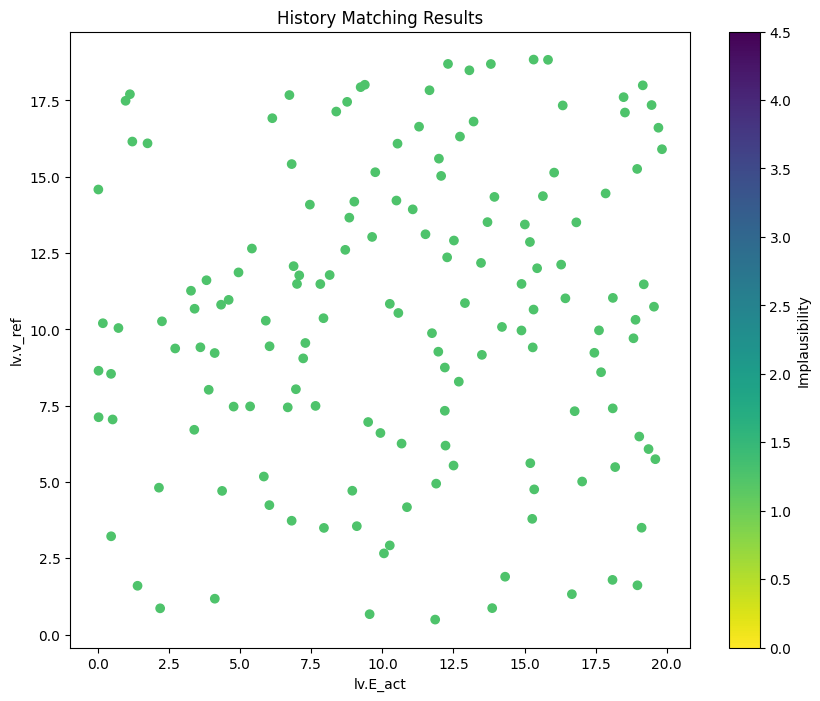


Best parameters found:
lv.E_act    10.562905
lv.v_ref    10.535169
la.E_act     3.630640
Name: 34, dtype: float64
Implausibility: 1.25


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Tuple, List
from autoemulate.compare import AutoEmulate
from autoemulate.history_matching import HistoryMatching
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Solver import Solver

class NaghaviHistoryMatcher:
    def __init__(self, observed_data: Dict[str, float], 
                 param_ranges: Dict[str, Tuple[float, float]],
                 n_cycles: int = 40, dt: float = 0.001,
                 implausibility_threshold: float = 3.0,
                 model_discrepancy: float = 0.0):
        """
        Initialize the history matching framework for Naghavi model
        
        Args:
            observed_data: Dictionary of target values {signal_name: target_value}
            param_ranges: Dictionary of parameter ranges {param_name: (min, max)}
            n_cycles: Number of cardiac cycles to simulate
            dt: Time step for simulation
            implausibility_threshold: Threshold for implausibility
            model_discrepancy: Model discrepancy term
        """
        self.observed_data = observed_data
        self.param_ranges = param_ranges
        self.param_names = list(param_ranges.keys())
        self.n_cycles = n_cycles
        self.dt = dt
        
        # Time setup dictionary
        self.time_setup = {
            "name": "HistoryMatching",
            "ncycles": n_cycles,
            "tcycle": 1.0,
            "dt": dt,
            "export_min": 1
        }
        
        # Initialize emulator
        self.emulator = None
        self.emulator_trained = False
        
        # History matching setup
        self.history_matcher = HistoryMatching(
            threshold=implausibility_threshold,
            discrepancy=model_discrepancy,
            rank=1
        )

    def run_simulation(self, params: Dict[str, float]) -> Dict[str, float]:
        """
        Run a single Naghavi model simulation with given parameters
        Returns dictionary of output values {signal_name: value}
        """
        # Create parameter object
        parobj = NaghaviModelParameters()
        
        # Set parameters from input
        for param_name, value in params.items():
            if param_name == "T":
                continue  # Handle cycle time separately
            try:
                obj, param = param_name.split('.')
                parobj._set_comp(obj, [obj], **{param: value})
            except Exception as e:
                print(f"Error setting parameter {param_name}: {e}")
                return None
        
        # Adjust cycle time if specified
        t_cycle = params.get("T", 1.0)
        self.time_setup["tcycle"] = t_cycle
        
        # Create and run model
        try:
            model = NaghaviModel(time_setup_dict=self.time_setup, parobj=parobj, suppress_printing=True)
            solver = Solver(model=model)
            solver.setup(suppress_output=True, optimize_secondary_sv=False, conv_cols=["p_ao"], method='LSODA')
            solver.solve()
            
            if not solver.converged:
                return None
        except Exception as e:
            print(f"Simulation error: {e}")
            return None
        
        # Process results - extract last cycle min/max values
        raw_results = {}
        tind_fin = np.arange(start=model.time_object.n_t-model.time_object.n_c,
                            stop=model.time_object.n_t)
        
        for signal_name in self.observed_data.keys():
            try:
                component, _ = signal_name.split('.')
                if component in model.components:
                    raw_signal = model.components[component].P_i.values[tind_fin]
                    
                    if '_min' in signal_name:
                        raw_results[signal_name] = np.min(raw_signal)
                    elif '_max' in signal_name:
                        raw_results[signal_name] = np.max(raw_signal)
                else:
                    print(f"Component {component} not found in model")
                    return None
            except Exception as e:
                print(f"Error extracting signal {signal_name}: {e}")
                return None
                
        return raw_results

    def train_emulator(self, X: np.ndarray, y: np.ndarray):
        """Train the GP emulator using autoemulate"""
        print("Training GP emulator...")
        em = AutoEmulate()
        em.setup(X, y, models=["gp"])
        self.emulator = em.compare()
        self.emulator_trained = True
        print(f"GP emulator trained on {len(X)} samples")

    def get_emulator_predictions(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get predictions from trained emulator
        Returns:
            pred_mean: Array of shape (n_samples, n_outputs)
            pred_var: Array of shape (n_samples, n_outputs)
        """
        if not self.emulator_trained:
            raise ValueError("Emulator not trained yet")
            
        pred_mean, pred_std = self.emulator.predict(X, return_std=True)
        pred_var = np.square(pred_std)
        return pred_mean, pred_var

    def generate_samples(self, n_samples: int) -> pd.DataFrame:
        """Generate random parameter samples"""
        samples = []
        for param_name, (low, high) in self.param_ranges.items():
            samples.append(np.random.uniform(low, high, n_samples))
        return pd.DataFrame(np.array(samples).T, columns=self.param_names)

    def run_wave(self, samples: pd.DataFrame, use_emulator: bool = False) -> Tuple[pd.DataFrame, np.ndarray]:
        """
        Run a wave of simulations or emulator predictions
        Returns:
            successful_samples: DataFrame of parameter sets
            impl_scores: Array of implausibility scores
        """
        if use_emulator and self.emulator_trained:
            # Use emulator for predictions
            X = samples[self.param_names].values
            pred_mean, pred_var = self.get_emulator_predictions(X)
            
            # Calculate implausibility for each sample
            impl_scores = []
            for i in range(len(samples)):
                predictions = [[pred_mean[i,j], pred_var[i,j]] 
                              for j in range(len(self.observed_data))]
                observations = [[obs, 0.1] for obs in self.observed_data.values()]
                
                result = self.history_matcher.history_matching(observations, predictions)
                impl_scores.append(result["I"][0])
                
            return samples, np.array(impl_scores)
        else:
            # Run actual simulations
            successful_samples = []
            impl_scores = []
            
            for _, row in tqdm(samples.iterrows(), total=len(samples)):
                params = row.to_dict()
                outputs = self.run_simulation(params)
                
                if outputs is None:
                    continue
                    
                # Prepare predictions and observations
                predictions = [[outputs[signal], 0.01]  # Small fixed variance
                              for signal in self.observed_data]
                observations = [[obs, 0.1]  # Observation variance
                              for obs in self.observed_data.values()]
                
                result = self.history_matcher.history_matching(observations, predictions)
                impl_scores.append(result["I"][0])
                successful_samples.append(params)
            
            return pd.DataFrame(successful_samples), np.array(impl_scores)

    def history_matching(self, n_waves: int = 3, n_samples_per_wave: int = 100, 
                        use_emulator: bool = False):
        """
        Perform iterative history matching
        Returns:
            all_samples: DataFrame of all evaluated parameter sets
            all_impl_scores: Array of corresponding implausibility scores
        """
        current_samples = self.generate_samples(n_samples_per_wave)
        all_samples = pd.DataFrame()
        all_impl_scores = np.array([])
        
        for wave in range(n_waves):
            print(f"\n=== Wave {wave + 1}/{n_waves} ===")
            
            # Determine if we should use emulator (after first wave if enabled)
            wave_use_emulator = use_emulator and (wave > 0) and self.emulator_trained
            
            # Run the wave
            successful_samples, impl_scores = self.run_wave(
                current_samples, 
                use_emulator=wave_use_emulator
            )
            
            print(f"Evaluated {len(successful_samples)} samples")
            print(f"Min implausibility: {np.min(impl_scores):.2f}")
            print(f"Max implausibility: {np.max(impl_scores):.2f}")
            
            # Store results
            all_samples = pd.concat([all_samples, successful_samples])
            all_impl_scores = np.concatenate([all_impl_scores, impl_scores])
            
            # Identify Not Ruled Out Yet (NROY) points
            nroy_mask = impl_scores <= self.history_matcher.threshold
            nroy_samples = successful_samples[nroy_mask]
            print(f"NROY points: {len(nroy_samples)}")
            
            # Train emulator after first wave if requested
            if wave == 0 and use_emulator and len(successful_samples) > 10:
                X_train = successful_samples[self.param_names].values
                # Collect all outputs for training data
                y_train = []
                for _, row in successful_samples.iterrows():
                    outputs = self.run_simulation(row.to_dict())
                    if outputs is not None:
                        y_train.append([outputs[signal] for signal in self.observed_data])
                y_train = np.array(y_train)
                self.train_emulator(X_train, y_train)
            
            # Generate new samples for next wave
            if wave < n_waves - 1:
                if len(nroy_samples) >= 2:
                    # Sample from NROY space
                    new_samples = self.history_matcher._sample_new_points(
                        nroy_samples[self.param_names].values, 
                        n_samples_per_wave
                    )
                    current_samples = pd.DataFrame(new_samples, columns=self.param_names)
                else:
                    # Fall back to random sampling
                    print("Not enough NROY points - using random sampling")
                    current_samples = self.generate_samples(n_samples_per_wave)
        
        return all_samples, all_impl_scores

    def plot_results(self, samples: pd.DataFrame, impl_scores: np.ndarray):
        """Plot 2D parameter space with implausibility"""
        if len(self.param_names) < 2:
            return
            
        fig, ax = plt.subplots(figsize=(10, 8))
        sc = ax.scatter(samples[self.param_names[0]], 
                        samples[self.param_names[1]], 
                        c=impl_scores,
                        cmap='viridis_r',
                        vmin=0,
                        vmax=self.history_matcher.threshold*1.5)
        
        ax.set_xlabel(self.param_names[0])
        ax.set_ylabel(self.param_names[1])
        ax.set_title("History Matching Results")
        plt.colorbar(sc, label='Implausibility')
        plt.show()


# Example usage
if __name__ == "__main__":
    # Define observed data (target values)
    observed_signals = {
        "ao.P_min": 80.0,    # Minimum aortic pressure (mmHg)
        "ao.P_max": 120.0,   # Maximum aortic pressure (mmHg)
    }

    # Define parameter ranges to explore
    param_ranges = {
        "lv.E_act": (0.0, 20.0),  # LV active elastance
        "lv.v_ref": (0.0, 20.0),  # LV reference volume
        "la.E_act": (0.0, 10.5),  # LA active elastance
    }

    # Create history matcher instance
    hm = NaghaviHistoryMatcher(
        observed_data=observed_signals,
        param_ranges=param_ranges,
        implausibility_threshold=3.0
    )

    # Run history matching (with emulator after first wave)
    all_samples, all_impl_scores = hm.history_matching(
        n_waves=3,
        n_samples_per_wave=50,
        use_emulator=True
    )

    # Plot results
    hm.plot_results(all_samples, all_impl_scores)

    # Print best parameters
    best_idx = np.argmin(all_impl_scores)
    print("\nBest parameters found:")
    print(all_samples.iloc[best_idx])
    print(f"Implausibility: {all_impl_scores[best_idx]:.2f}")